In [1]:
import pyconll
import os
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from bidi.algorithm import get_display

## The issue at hand
 
We'd like to have a way to store 3D data - a frequencies dictoinary of a certain part of speech and a relation combination.
We'd like the data to be able to be extracted using the specific name of the POS and the relation, rather than by an index (or 3 indices, for 3D data).

## A solution

We'll create a pandas Dataframe which holds 2D data. We'll achive the searching by name goal by heaving its rows and coloumns named according to the POS and the relations (and using the "at" method, for example).

Since the Dataframe was not able to hold a dictionary in it, but is able to hold other, custom-made, objects we'll create a Token_dictionary object for it to hold.

The Token_dictionary object made delegates some of its methods to the regular dictionary object, which is its only attribute - which gives us the 3rd dimention of the data. In addition, it also has methods which the regular dictionary does not.

In [2]:
class token_dictionary:
    def __init__(self):
        self.dictionary = {}

    def order(self):
        self.dictionary = {k: v for k, v in sorted(self.dictionary.items(), key=lambda item: item[1], reverse=True)}
        
    def length(self):
        return len(self.dictionary)
    
    def increment(self, key):
        if key in self.dictionary:
            self.dictionary[key]+=1
        else:
            self.dictionary[key]=1
                
    def print_top_words(self, i = 1):
        if i>self.length():
            i=self.length()
        for key, value in self.dictionary.items():
            if i>0:
                print (f"{key}: {value}")
                i-=1
            else:
                break
    
    def print_dic(self):
        print (self.dictionary)


## Some functions to make the Main clearer

In [3]:
def get_pos_and_relations():
    
    """
    Retrieve lists of Part-of-Speech (POS) tags and dependency relations.

    Returns:
    - pos (list): A list of POS tags.
    - relations (list): A list of dependency relations.

    Dependencies:
    - None
    """
        
    # loading all the POS and relations
    pos = [
    "ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET",
    "INTJ", "NOUN", "NUM", "PART", "PRON", "PROPN",
    "PUNCT", "SCONJ", "SYM", "VERB", "X"
            ]
    
        # relations gathered from the UD site: https://universaldependencies.org/u/dep/index.html
    relations_from_site = [
    "acl", "acl:relcl", "advcl", "advcl:relcl", "advmod", "advmod:emph",
    "advmod:lmod", "amod", "appos", "aux", "aux:pass", "case", "cc",
    "cc:preconj", "ccomp", "clf", "compound", "compound:lvc", "compound:prt",
    "compound:redup", "compound:svc", "conj", "cop", "csubj", "csubj:outer",
    "csubj:pass", "dep", "det", "det:numgov", "det:nummod", "det:poss",
    "discourse", "dislocated", "expl", "expl:impers", "expl:pass", "expl:pv",
    "fixed", "flat", "flat:foreign", "flat:name", "goeswith", "iobj", "list",
    "mark", "nmod", "nmod:poss", "nmod:tmod", "nsubj", "nsubj:outer",
    "nsubj:pass", "nummod", "nummod:gov", "obj", "obl", "obl:agent",
    "obl:arg", "obl:lmod", "obl:tmod", "orphan", "parataxis", "punct",
    "reparandum", "root", "vocative", "xcomp"
                            ]
        # relations which were only in the data
    relations_from_data = ["compound:affix", "obl:npmod", "nmod:npmod"]

    relations = relations_from_site + relations_from_data
    relations.sort()
    
    return pos, relations

In [4]:
def empty_matrix():
    
    """
    Creates an empty matrix (Pandas DataFrame) initialized with None values.

    Returns:
    - pandas.DataFrame: An empty DataFrame with rows representing POS tags
                        and columns representing dependency relations,
                        initialized with None values.

    Dependencies:
    - get_pos_and_relations
    - pandas
    - numpy
    """
        
    pos, relations = get_pos_and_relations()
    
    # creating a pandas dataframe whose rows are the POS and whose columns are the relations
    # it is first initiallized with np.NaNs which are then replaced to None
    
    colomns_number = len(relations)
    rows_number = len(pos)

    df = pd.DataFrame(np.full((rows_number, colomns_number), fill_value = np.NaN), index = pos, columns = relations)
    df.replace({np.nan:None}, inplace=True)
            
    # returning the pos_relation_matrix
    return df

In [5]:
def fill_matrix(tokens, df):
    
    """
    Fill a matrix (Pandas DataFrame) with Token_dictionaty objects which contain updated information from a list of tokens.

    Parameters:
    - tokens (list): A list of token objects.
    - df (pandas.DataFrame): The empty DataFrame (made with the empty_matrix function) to be filled with information.

    The function iterates through the list of tokens and updates the DataFrame with
    information from each token. It checks if the DataFrame cell at the corresponding
    POS tag and dependency relation is empty (None), and if so, initializes it with
    a new instance of the 'token_dictionary' object. It then increments the count for
    the 'form' attribute in the 'token_dictionary'.

    Dependencies:
    - token_dictionary (class)
    - pandas
    """
    
    for token in tokens:
         if token.upos != None:
            if df.at[token.upos, token.deprel] == None:
                df.at[token.upos, token.deprel] = token_dictionary()
            df.at[token.upos, token.deprel].increment(token.form)

In [6]:
def order_matrix(df):
    
    """
    Order the values of the token_dictionary objects within each cell of a matrix (Pandas DataFrame).

    Parameters:
    - df (pandas.DataFrame): The DataFrame whose values are to be ordered.

    Dependencies:
    - pandas
    """
    
    df.applymap(lambda x: x if x == None else x.order())

In [7]:
def wordcloud(x):
    
    """
    Generate and display a word cloud based on a dictionary of word frequencies.

    Parameters:
    - x: A Token_dictionary object with a 'dictionary' attribute representing word frequencies.
         If x is None, a message is printed indicating that the corpus does not
         contain words of this type.

    This method utilizes the 'WordCloud' library to generate and display a word cloud
    based on the word frequencies in the provided dictionary. The dictionary has
    words as keys and their corresponding frequencies as values.

    Dependencies:
    - bidi.algorithm
    - WordCloud
    - matplotlib.pyplot
    """
    
    if x == None:
        print("The corpus does not contain words of this type.")
    else:
        display_dic = {get_display(k): v for k, v in (x.dictionary.items())}
        wc = WordCloud(font_path='calibri.ttf')
        wc.generate_from_frequencies(display_dic)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.show()

## Main

In [8]:
conll_files = []

directory = "C:\Python\IAHLT\Data"
for file in os.listdir(directory):
        conll_files.append(pyconll.load_from_file(directory + "\\" + file))

In [9]:
all_tokens = []
for file in conll_files:
    for sentence in file:
         for token in sentence:
            all_tokens.append(token)

In [10]:
matrix = empty_matrix()
fill_matrix(all_tokens, matrix)
order_matrix(matrix)

In [11]:
matrix.head()

,acl,acl:relcl,advcl,advcl:relcl,advmod,advmod:emph,advmod:lmod,amod,appos,aux,...,obl:lmod,obl:npmod,obl:tmod,orphan,parataxis,punct,reparandum,root,vocative,xcomp
ADJ,<__main__.token_dictionary object at 0x0000017...,<__main__.token_dictionary object at 0x0000017...,<__main__.token_dictionary object at 0x0000017...,None,<__main__.token_dictionary object at 0x0000017...,None,None,<__main__.token_dictionary object at 0x0000017...,<__main__.token_dictionary object at 0x0000017...,None,...,None,<__main__.token_dictionary object at 0x0000017...,None,<__main__.token_dictionary object at 0x0000017...,<__main__.token_dictionary object at 0x0000017...,None,None,<__main__.token_dictionary object at 0x0000017...,None,<__main__.token_dictionary object at 0x0000017...
ADP,None,<__main__.token_dictionary object at 0x0000017...,<__main__.token_dictionary object at 0x0000017...,None,<__main__.token_dictionary object at 0x0000017...,None,None,<__main__.token_dictionary object at 0x0000017...,None,None,...,None,None,None,<__main__.token_dictionary object at 0x0000017...,None,None,<__main__.token_dictionary object at 0x0000017...,None,None,None
ADV,<__main__.token_dictionary object at 0x0000017...,<__main__.token_dictionary object at 0x0000017...,<__main__.token_dictionary object at 0x0000017...,None,<__main__.token_dictionary object at 0x0000017...,None,None,<__main__.token_dictionary object at 0x0000017...,<__main__.token_dictionary object at 0x0000017...,None,...,None,None,<__main__.token_dictionary object at 0x0000017...,<__main__.token_dictionary object at 0x0000017...,<__main__.token_dictionary object at 0x0000017...,None,None,<__main__.token_dictionary object at 0x0000017...,None,<__main__.token_dictionary object at 0x0000017...
AUX,None,<__main__.token_dictionary object at 0x0000017...,<__main__.token_dictionary object at 0x0000017...,None,None,None,None,None,None,<__main__.token_dictionary object at 0x0000017...,...,None,None,None,None,<__main__.token_dictionary object at 0x0000017...,None,<__main__.token_dictionary object at 0x0000017...,<__main__.token_dictionary object at 0x0000017...,None,<__main__.token_dictionary object at 0x0000017...
CCONJ,None,None,<__main__.token_dictionary object at 0x0000017...,None,<__main__.token_dictionary object at 0x0000017...,None,None,None,None,None,...,None,None,None,None,<__main__.token_dictionary object at 0x0000017...,None,<__main__.token_dictionary object at 0x0000017...,None,None,None


In [16]:
matrix.at["ADJ", "acl"].print_top_words(10)

ראוי: 3
עוקף: 2
מחוזקים: 1
קיימת: 1
עוקפת: 1
מוחלטים: 1
עשויים: 1
קיימות: 1
ראויה: 1
תלויה: 1


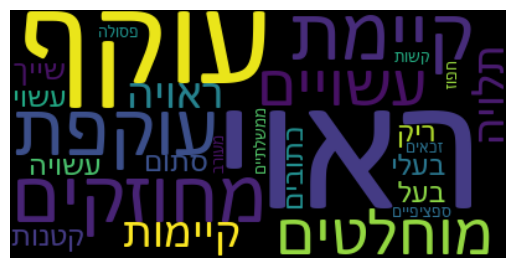

In [13]:
wordcloud(matrix.at["ADJ", "acl"])

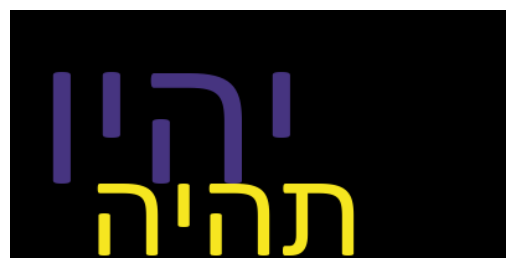

In [14]:
wordcloud(matrix.at["AUX", "advcl"])

In [15]:
wordcloud(matrix.at["ADP", "acl"])

The corpus does not contain words of this type.
